<a href="https://colab.research.google.com/github/Zhangmingyang-Su/ads-project/blob/master/Click_Through_Rate_Predcition_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic: Click through rate - dataset by kaggle

## Main Procedures:
#### 1. Spark envrionment setup
#### 2. EDA
#### 3. Feature Preprocessing
#### 4. ML Model Selection
#### 5. Feature Importance
#### 6. Insight from Conclusion

##0. Spark Setup

In [10]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.mirrors.hoobly.com/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install py4j

^C


In [11]:
!ls

filtered_train.csv	   spark-2.4.5-bin-hadoop2.7.tgz
sample_data		   spark-2.4.5-bin-hadoop2.7.tgz.1
spark-2.4.5-bin-hadoop2.7


In [12]:
!export JAVA_HOME=$(/usr/lib/jvm/java-8-openjdk-amd64 -v 1.8)

/bin/bash: /usr/lib/jvm/java-8-openjdk-amd64: Is a directory


In [13]:
! echo $JAVA_HOME

/usr/lib/jvm/java-8-openjdk-amd64


In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
import findspark
findspark.init("spark-2.4.5-bin-hadoop2.7")# SPARK_HOME

from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [15]:
spark.version

'2.4.5'

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

## *. Read data from local machine

In [17]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

KeyboardInterrupt: ignored

In [18]:
!ls

filtered_train.csv	   spark-2.4.5-bin-hadoop2.7.tgz
sample_data		   spark-2.4.5-bin-hadoop2.7.tgz.1
spark-2.4.5-bin-hadoop2.7


In [19]:
import os 
os.listdir('./sample_data')

['anscombe.json',
 'README.md',
 'mnist_test.csv',
 'california_housing_train.csv',
 'mnist_train_small.csv',
 'california_housing_test.csv']

##1. EDA

In [0]:
impression = spark.read.csv("filtered_train.csv", inferSchema=True, header=True )

In [22]:
impression.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- id: double (nullable = true)
 |-- click: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- C1: integer (nullable = true)
 |-- banner_pos: integer (nullable = true)
 |-- site_id: string (nullable = true)
 |-- site_domain: string (nullable = true)
 |-- site_category: string (nullable = true)
 |-- app_id: string (nullable = true)
 |-- app_domain: string (nullable = true)
 |-- app_category: string (nullable = true)
 |-- device_id: string (nullable = true)
 |-- device_ip: string (nullable = true)
 |-- device_model: string (nullable = true)
 |-- device_type: integer (nullable = true)
 |-- device_conn_type: integer (nullable = true)
 |-- C14: integer (nullable = true)
 |-- C15: integer (nullable = true)
 |-- C16: integer (nullable = true)
 |-- C17: integer (nullable = true)
 |-- C18: integer (nullable = true)
 |-- C19: integer (nullable = true)
 |-- C20: integer (nullable = true)
 |-- C21: integer (nullable = true)



In [23]:
impression.show()

+------+--------------------+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+----+------+---+
|   _c0|                  id|click|    hour|  C1|banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type|  C14|C15|C16| C17|C18| C19|   C20|C21|
+------+--------------------+-----+--------+----+----------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+-----------+----------------+-----+---+---+----+---+----+------+---+
|128037|1.107450855228460...|    0|14102101|1005|         1|e151e245|   7e091613|     f028772b|ecad2386|  7801e8d9|    07d7df22| a99f214a| 10dcdfb1|    88fe1d5d|          1|               0|20352|320| 50|2333|  0|  39|    -1|157|
|491755|1.240012241576984...|    0|14102103|1005|         0|1fbe01fe|   f3845767

In [24]:
print("impression size: " + str(impression.count()))

impression size: 404290


In [0]:
# sql tempview
impression.createOrReplaceTempView("impression")

###1.1. Banner Position

In [26]:
# Banner Position for SQL
Banner_position = spark.sql('''select banner_pos, 
                               count(*) as nums 
                               from impression 
                               group by 1 
                               order by 1''')
Banner_position.show()

+----------+------+
|banner_pos|  nums|
+----------+------+
|         0|291180|
|         1|112416|
|         2|   111|
|         3|    20|
|         4|    69|
|         5|    57|
|         7|   437|
+----------+------+



In [0]:
# from spark sql to Pandas Dataframe
Banner_position_df = Banner_position.toPandas()

<Figure size 432x288 with 0 Axes>

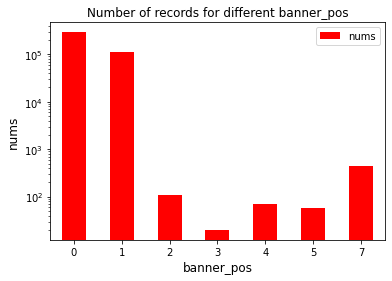

In [28]:
import matplotlib.pyplot as plt

# data visualization
plt.figure()
ax = Banner_position_df.plot(kind = 'bar', x = 'banner_pos', y = 'nums', logy = True, color = 'red', legend = True, align = 'center')
ax.set_xlabel('banner_pos', fontsize = 12)
ax.set_ylabel('nums', fontsize = 12)
plt.xticks(fontsize=10, rotation = 0)
plt.title('Number of records for different banner_pos')
display()

###1.2. click and no_click numbers by Banner Position

In [29]:
click_no_click = spark.sql('''select banner_pos, 
                              sum(case when click = 1 then 1 else 0 end) as click, 
                              sum(case when click = 0 then 1 else 0 end) as no_click 
                              from impression 
                              group by 1 
                              order by 1''')
click_no_click.show()

+----------+-----+--------+
|banner_pos|click|no_click|
+----------+-----+--------+
|         0|47939|  243241|
|         1|20542|   91874|
|         2|   12|      99|
|         3|    5|      15|
|         4|   12|      57|
|         5|    6|      51|
|         7|  139|     298|
+----------+-----+--------+



In [0]:
# from spark sql to Pandas Dataframe
click_no_click_df = click_no_click.toPandas()

<Figure size 432x288 with 0 Axes>

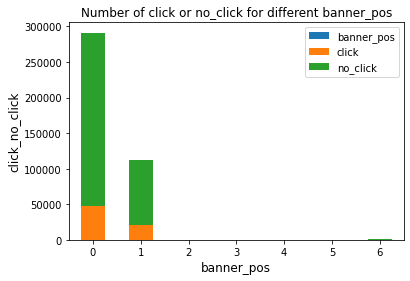

In [31]:
# data visualization
plt.figure()
ax = click_no_click_df.plot(kind = 'bar', stacked=True)
ax.set_xlabel('banner_pos', fontsize = 12)
ax.set_ylabel('click_no_click', fontsize = 12)
plt.xticks(fontsize=10, rotation = 0)
plt.title('Number of click or no_click for different banner_pos')
display()

###1.3. CTR by Banner Position

In [32]:
ctr_pos = spark.sql('''select banner_pos,
                       sum(case when click = 1 then 1 else 0 end) / count(*) as ctr
                       from impression
                       group by 1
                       order by 1''')
ctr_pos.show()

+----------+-------------------+
|banner_pos|                ctr|
+----------+-------------------+
|         0|  0.164636994299059|
|         1|0.18273199544548818|
|         2|0.10810810810810811|
|         3|               0.25|
|         4|0.17391304347826086|
|         5|0.10526315789473684|
|         7| 0.3180778032036613|
+----------+-------------------+



In [0]:
# from spark sql to Pandas Dataframe
ctr_pos_df = ctr_pos.toPandas()

<Figure size 432x288 with 0 Axes>

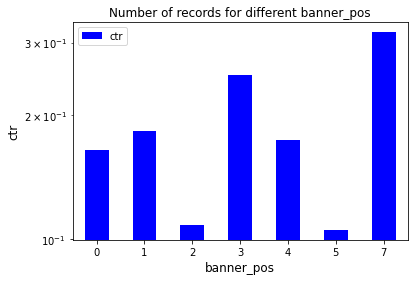

In [34]:
# data visualization
plt.figure()
ax = ctr_pos_df.plot(kind = 'bar', x = 'banner_pos', y = 'ctr', logy = True, color = 'blue', legend = True, align = 'center')
ax.set_xlabel('banner_pos', fontsize = 12)
ax.set_ylabel('ctr', fontsize = 12)
plt.xticks(fontsize=10, rotation = 0)
plt.title('Number of records for different banner_pos')
display()

###1.4. device_type

In [35]:
device_type = spark.sql('''select device_type,
                           count(*) as nums
                           from impression
                           group by 1
                           order by 1''')
device_type.show()

+-----------+------+
|device_type|  nums|
+-----------+------+
|          0| 22063|
|          1|373227|
|          4|  7703|
|          5|  1297|
+-----------+------+



In [0]:
# from spark sql to Pandas Dataframe
device_type_df = device_type.toPandas()

<Figure size 432x288 with 0 Axes>

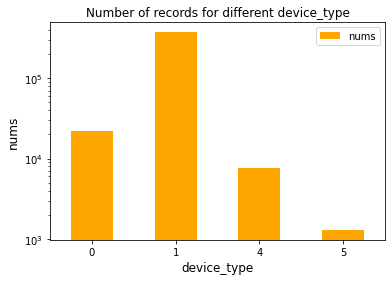

In [42]:
# data visualization
plt.figure()
ax = device_type_df.plot(kind = 'bar', x = 'device_type', y = 'nums', logy = True, color = 'orange', legend = True, align = 'center')
ax.set_xlabel('device_type', fontsize = 12)
ax.set_ylabel('nums', fontsize = 12)
plt.xticks(fontsize=10, rotation = 0)
plt.title('Number of records for different device_type')
display()

###1.5. click and no_click numbers by device_type

In [36]:
device_type_click_no_click = spark.sql('''select device_type,
                                          sum(case when click = 1 then 1 else 0 end) as click,
                                          sum(case when click = 0 then 1 else 0 end) as no_click
                                          from impression
                                          group by 1
                                          order by 1''')
device_type_click_no_click.show()

+-----------+-----+--------+
|device_type|click|no_click|
+-----------+-----+--------+
|          0| 4781|   17282|
|          1|63033|  310194|
|          4|  731|    6972|
|          5|  110|    1187|
+-----------+-----+--------+



In [0]:
# from spark sql to Pandas Dataframe
device_type_click_no_click_df = device_type_click_no_click.toPandas()

<Figure size 432x288 with 0 Axes>

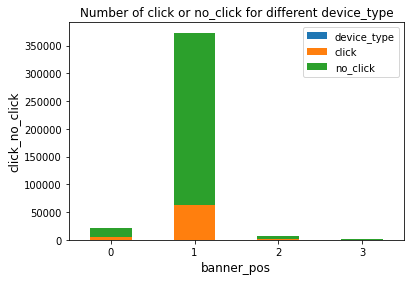

In [44]:
# data visualization
plt.figure()
ax = device_type_click_no_click_df.plot(kind = 'bar', stacked=True)
ax.set_xlabel('banner_pos', fontsize = 12)
ax.set_ylabel('click_no_click', fontsize = 12)
plt.xticks(fontsize=10, rotation = 0)
plt.title('Number of click or no_click for different device_type')
display()

###1.6. CTR by device_type

In [37]:
ctr_device_type = spark.sql('''select device_type,
                               sum(case when click = 1 then 1 else 0 end) / count(*) as ctr
                               from impression
                               group by 1
                               order by 1''')
ctr_device_type.show()

+-----------+-------------------+
|device_type|                ctr|
+-----------+-------------------+
|          0|0.21669763858042876|
|          1|0.16888649535001488|
|          4|0.09489809165260288|
|          5|0.08481110254433308|
+-----------+-------------------+



In [0]:
# from spark sql to Pandas Dataframe
ctr_device_type_df = ctr_device_type.toPandas()

<Figure size 432x288 with 0 Axes>

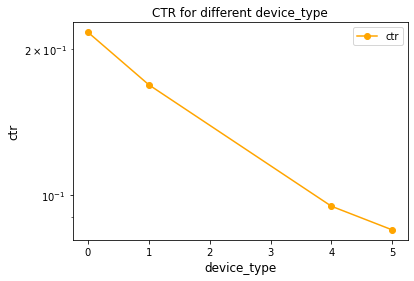

In [51]:
plt.figure()
ax = ctr_device_type_df.plot(kind = 'line', x = 'device_type', y = 'ctr', logy = True, color = 'orange', marker= 'o', legend = True)
ax.set_xlabel('device_type', fontsize = 12)
ax.set_ylabel('ctr', fontsize = 12)
plt.xticks(fontsize=10, rotation = 0)
plt.yticks(fontsize=10, rotation = 0)
plt.title('CTR for different device_type')
display()

###1.7. Site Category

In [52]:
site_category = spark.sql('''select site_category,
                             count(*) as nums
                             from impression
                             group by 1
                             having nums > 200
                             order by 2 desc''')
site_category.show()

+-------------+------+
|site_category|  nums|
+-------------+------+
|     50e219e0|165632|
|     f028772b|126494|
|     28905ebd| 73611|
|     3e814130| 30335|
|     f66779e6|  2548|
|     75fa27f6|  1662|
|     335d28a8|  1339|
|     76b2941d|  1107|
|     c0dd3be3|   426|
|     72722551|   287|
|     dedf689d|   265|
|     70fb0e29|   251|
+-------------+------+



In [0]:
# from spark sql to Pandas Dataframe
site_category_df = site_category.toPandas()

<Figure size 432x288 with 0 Axes>

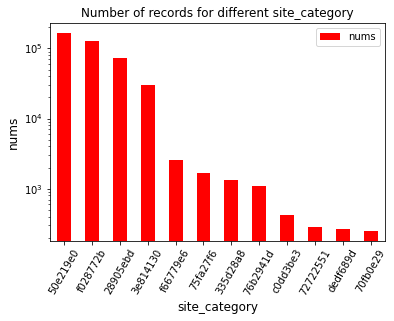

In [56]:
# data visualization
plt.figure()
ax = site_category_df.plot(kind = 'bar', x = 'site_category', y = 'nums', logy = True, color = 'red', legend = True, align = 'center')
ax.set_xlabel('site_category', fontsize = 12)
ax.set_ylabel('nums', fontsize = 12)
plt.xticks(fontsize=10, rotation = 60)
plt.title('Number of records for different site_category')
display()

###1.8. click and no_click numbers by different Site Category

In [58]:
site_category_click_no_click = spark.sql('''select site_category,
                                            sum(case when click = 1 then 1 else 0 end) as click,
                                            sum(case when click = 0 then 1 else 0 end) as no_click
                                            from impression
                                            group by 1
                                            order by 3 desc''')
site_category_click_no_click.show()

+-------------+-----+--------+
|site_category|click|no_click|
+-------------+-----+--------+
|     50e219e0|21349|  144283|
|     f028772b|22664|  103830|
|     28905ebd|15399|   58212|
|     3e814130| 8536|   21799|
|     f66779e6|  118|    2430|
|     75fa27f6|  175|    1487|
|     335d28a8|  117|    1222|
|     76b2941d|   23|    1084|
|     c0dd3be3|   51|     375|
|     72722551|   26|     261|
|     70fb0e29|   43|     208|
|     0569f928|    6|     155|
|     dedf689d|  135|     130|
|     8fd0aea4|    2|      72|
|     42a36e14|    9|      28|
|     a818d37a|    0|      28|
|     bcf865d9|    0|      14|
|     e787de0e|    0|      10|
|     5378d028|    2|       4|
|     c706e647|    0|       1|
+-------------+-----+--------+
only showing top 20 rows



In [0]:
# from spark sql to Pandas Dataframe
site_category_click_no_click_df = site_category_click_no_click.toPandas()

<Figure size 432x288 with 0 Axes>

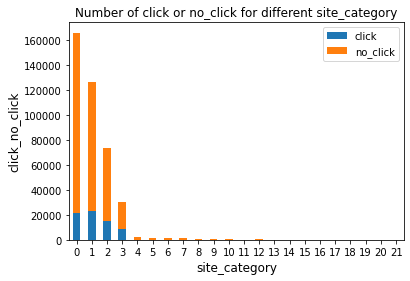

In [60]:
# data visualization
plt.figure()
ax = site_category_click_no_click_df.plot(kind = 'bar', stacked=True)
ax.set_xlabel('site_category', fontsize = 12)
ax.set_ylabel('click_no_click', fontsize = 12)
plt.xticks(fontsize=10, rotation = 0)
plt.title('Number of click or no_click for different site_category')
display()

###1.9. CTR by Site Category

In [69]:
ctr_site_category = spark.sql('''select site_category,
                                 sum(case when click = 1 then 1 else 0 end) / count(*) as ctr
                                 from impression
                                 group by 1
                                 order by 2 desc''')
ctr_site_category.show()

+-------------+--------------------+
|site_category|                 ctr|
+-------------+--------------------+
|     dedf689d|  0.5094339622641509|
|     5378d028|  0.3333333333333333|
|     3e814130|  0.2813911323553651|
|     42a36e14| 0.24324324324324326|
|     28905ebd|  0.2091942780290989|
|     f028772b| 0.17917055354404163|
|     70fb0e29| 0.17131474103585656|
|     50e219e0| 0.12889417503863987|
|     c0dd3be3| 0.11971830985915492|
|     75fa27f6| 0.10529482551143202|
|     72722551| 0.09059233449477352|
|     335d28a8| 0.08737864077669903|
|     f66779e6| 0.04631083202511774|
|     0569f928|0.037267080745341616|
|     8fd0aea4| 0.02702702702702703|
|     76b2941d| 0.02077687443541102|
|     e787de0e|                 0.0|
|     bcf865d9|                 0.0|
|     a72a0145|                 0.0|
|     c706e647|                 0.0|
+-------------+--------------------+
only showing top 20 rows



In [0]:
# from spark sql to Pandas Dataframe
ctr_site_category_df = ctr_site_category.toPandas()

<Figure size 432x288 with 0 Axes>

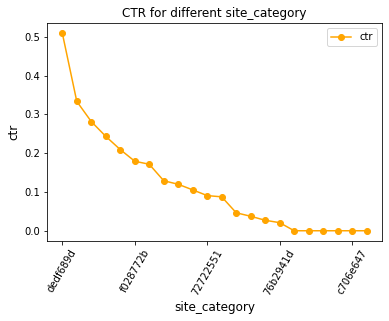

In [86]:
# visualization
plt.figure()
ax = ctr_site_category_df.plot(kind = 'line', x = 'site_category', y = 'ctr', logy = False, color = 'orange', marker= 'o', legend = True)
ax.set_xlabel('site_category', fontsize = 12)
ax.set_ylabel('ctr', fontsize = 12)
plt.xticks(fontsize=10, rotation = 60)
plt.yticks(fontsize=10, rotation = 0)
plt.title('CTR for different site_category')
display()

###1.10. Hour of Day

In [87]:
hour_day = spark.sql('''select substr(hour, 7) as hour,
                        count(*) as nums
                        from impression
                        group by 1
                        order by 1''')
hour_day.show()

+----+-----+
|hour| nums|
+----+-----+
|  00| 8531|
|  01| 9928|
|  02|12282|
|  03|14112|
|  04|18990|
|  05|19625|
|  06|17741|
|  07|18637|
|  08|20991|
|  09|22747|
|  10|21362|
|  11|20585|
|  12|22253|
|  13|23907|
|  14|21943|
|  15|20863|
|  16|20252|
|  17|20547|
|  18|17674|
|  19|13180|
+----+-----+
only showing top 20 rows



In [0]:
# from spark sql to Pandas Dataframe
hour_day_df = hour_day.toPandas()

<Figure size 432x288 with 0 Axes>

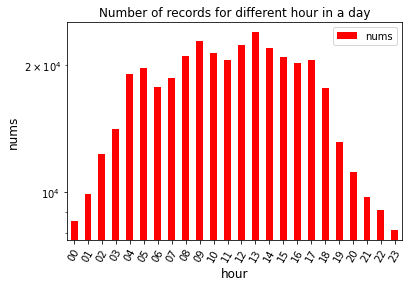

In [89]:
# data visualization
plt.figure()
ax = hour_day_df.plot(kind = 'bar', x = 'hour', y = 'nums', logy = True, color = 'red', legend = True, align = 'center')
ax.set_xlabel('hour', fontsize = 12)
ax.set_ylabel('nums', fontsize = 12)
plt.xticks(fontsize=10, rotation = 60)
plt.title('Number of records for different hour in a day')
display()

###1.11 click and no_click numbers by different hour of a day

In [90]:
hour_day_click_no_click = spark.sql('''select substr(hour, 7) as hour,
                                       sum(case when click = 1 then 1 else 0 end) as click,
                                       sum(case when click = 0 then 1 else 0 end) as no_click
                                       from impression
                                       group by 1
                                       order by 1''')
hour_day_click_no_click.show()

+----+-----+--------+
|hour|click|no_click|
+----+-----+--------+
|  00| 1572|    6959|
|  01| 1811|    8117|
|  02| 2134|   10148|
|  03| 2436|   11676|
|  04| 3089|   15901|
|  05| 3193|   16432|
|  06| 3058|   14683|
|  07| 3346|   15291|
|  08| 3387|   17604|
|  09| 3591|   19156|
|  10| 3429|   17933|
|  11| 3534|   17051|
|  12| 3870|   18383|
|  13| 3982|   19925|
|  14| 3836|   18107|
|  15| 3849|   17014|
|  16| 3593|   16659|
|  17| 3596|   16951|
|  18| 2959|   14715|
|  19| 2101|   11079|
+----+-----+--------+
only showing top 20 rows



In [0]:
# from spark sql to Pandas Dataframe
hour_day_click_no_click_df = hour_day_click_no_click.toPandas()

<Figure size 432x288 with 0 Axes>

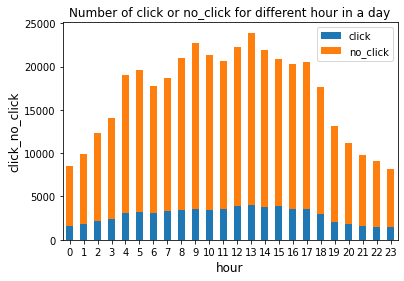

In [92]:
# data visualization
plt.figure()
ax = hour_day_click_no_click_df.plot(kind = 'bar', stacked=True)
ax.set_xlabel('hour', fontsize = 12)
ax.set_ylabel('click_no_click', fontsize = 12)
plt.xticks(fontsize=10, rotation = 0)
plt.title('Number of click or no_click for different hour in a day')
display()

###1.11. CTR by hour of a day

In [93]:
ctr_hour_day = spark.sql('''select substr(hour, 7) as hour,
                            sum(case when click = 1 then 1 else 0 end) / count(*) as ctr
                            from impression
                            group by 1
                            order by 1''')
ctr_hour_day.show()

+----+-------------------+
|hour|                ctr|
+----+-------------------+
|  00|0.18426913609190013|
|  01| 0.1824133763094279|
|  02|0.17375020354991044|
|  03|0.17261904761904762|
|  04|0.16266456029489204|
|  05|0.16270063694267517|
|  06|0.17236908855194183|
|  07|0.17953533293985083|
|  08|0.16135486637130197|
|  09| 0.1578669714687651|
|  10|0.16051867802640202|
|  11| 0.1716784066067525|
|  12| 0.1739091358468521|
|  13|0.16656209478395448|
|  14|0.17481657020462107|
|  15|0.18448928725494895|
|  16|0.17741457633813945|
|  17|  0.175013383948995|
|  18|0.16742107049903812|
|  19| 0.1594081942336874|
+----+-------------------+
only showing top 20 rows



In [0]:
# from spark sql to Pandas Dataframe
ctr_hour_day_df = ctr_hour_day.toPandas()

<Figure size 432x288 with 0 Axes>

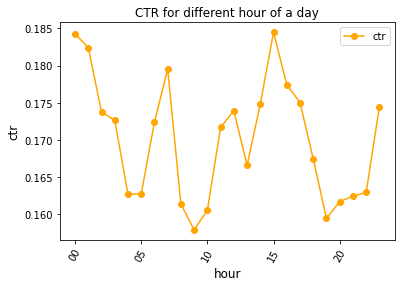

In [95]:
# visualization
plt.figure()
ax = ctr_hour_day_df.plot(kind = 'line', x = 'hour', y = 'ctr', logy = False, color = 'orange', marker= 'o', legend = True)
ax.set_xlabel('hour', fontsize = 12)
ax.set_ylabel('ctr', fontsize = 12)
plt.xticks(fontsize=10, rotation = 60)
plt.yticks(fontsize=10, rotation = 0)
plt.title('CTR for different hour of a day')
display()

###1.12. Cardinality of distinct column values


In [96]:
cardinality_distinct_values = spark.sql('''
                                            select 
                                            count(*) as total,

                                            count(distinct C1) as C1,
                                            count(distinct banner_pos) as banner_pos,
                                            count(distinct site_id) as site_id,
                                            count(distinct site_domain) as site_domain,
                                            count(distinct site_category) as site_category,
                                            count(distinct app_id) as app_id,
                                            count(distinct app_domain) as app_domain,
                                            count(distinct app_category) as app_category,
                                            count(distinct device_id) as device_id,
                                            count(distinct device_ip) as device_ip,
                                            count(distinct device_model) as device_model,
                                            count(distinct device_type) as device_type,
                                            count(distinct device_conn_type) as device_conn_type,
                                            count(distinct C14) as C14,
                                            count(distinct C15) as C15,
                                            count(distinct C16) as C16,
                                            count(distinct C17) as C17,
                                            count(distinct C18) as C18,
                                            count(distinct C19) as C19,
                                            count(distinct C20) as C20,
                                            count(distinct C21) as C21
                                            from impression''')

cardinality_distinct_values.show()

+------+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+----+---+---+---+---+---+---+---+
| total| C1|banner_pos|site_id|site_domain|site_category|app_id|app_domain|app_category|device_id|device_ip|device_model|device_type|device_conn_type| C14|C15|C16|C17|C18|C19|C20|C21|
+------+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+----+---+---+---+---+---+---+---+
|404290|  7|         7|   2225|       2188|           22|  2241|       143|          27|    64742|   261706|        4380|          4|               4|2088|  8|  9|411|  4| 65|161| 60|
+------+---+----------+-------+-----------+-------------+------+----------+------------+---------+---------+------------+-----------+----------------+----+---+---+---+---+---+---+---+



In [98]:
impression.describe().show()

+-------+--------------------+--------------------+-------------------+--------------------+------------------+------------------+--------+-----------+-------------+--------+----------+------------+---------+---------+------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+
|summary|                 _c0|                  id|              click|                hour|                C1|        banner_pos| site_id|site_domain|site_category|  app_id|app_domain|app_category|device_id|device_ip|device_model|       device_type|  device_conn_type|              C14|               C15|               C16|               C17|               C18|               C19|              C20|              C21|
+-------+--------------------+--------------------+-------------------+--------------------+------------------+------------------+--------+-----------+-----------